### **Import Libraries**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

### **Import Datasets**

In [2]:
scores_dict = pd.read_csv(r'/content/season_data.csv')
playoff_dict = pd.read_csv(r'/content/playoff_data.csv')

### **Create In-Sample Datasets**

In [3]:
scores_in = scores_dict[scores_dict['Season'] < 2021]               # In-sample regular season data
playoff_in = playoff_dict[playoff_dict['Season'] < 'playoffs2021']  # In-sample playoff data

expansion1 = scores_dict[scores_dict['Season'] < 2004]              # First 3 regular seasons after 2000-2001 expansion
expansion2 = scores_in[scores_in['Season'] > 2017].reset_index()    # First 3 regular seasons after 2017-2018 expansion

In [4]:
scores_in.head()

,Date,Visitor,G_Vis,Home,G_Home,OT Ind,Season
0,2000-10-04,Colorado Avalanche,2.0,Dallas Stars,2.0,1,2001
1,2000-10-05,Ottawa Senators,4.0,Boston Bruins,4.0,1,2001
2,2000-10-05,Chicago Blackhawks,2.0,Buffalo Sabres,4.0,0,2001
3,2000-10-05,Detroit Red Wings,4.0,Calgary Flames,3.0,0,2001
4,2000-10-05,Vancouver Canucks,3.0,Philadelphia Flyers,6.0,0,2001


### **Ensure Internal Team Naming Consistency**

In [5]:
team_changes = {
    'Atlanta Thrashers': 'Winnipeg Jets',
    'Phoenix Coyotes': 'Arizona Coyotes',
    'Mighty Ducks of Anaheim': 'Anaheim Ducks'
    # Add more mappings as needed
}

def name_changes(df, team_changes):
  for i in range(0,len(df['Home'])):
    if df['Home'][i] in team_changes:
      df['Home'][i] = team_changes.get(df['Home'][i], df['Home'][i])
    if df['Visitor'][i] in team_changes:
      df['Visitor'][i] = team_changes.get(df['Visitor'][i], df['Visitor'][i])

name_changes(scores_in, team_changes)
name_changes(playoff_in, team_changes)
name_changes(expansion1, team_changes)
name_changes(expansion2, team_changes)

### **Analyze Goal Differences**

Regular Season Goal Differences

In [6]:
scores_in['G_HminusV'] = scores_in['G_Home'] - scores_in['G_Vis']
scores_in['G_VminusH'] = scores_in['G_Vis'] - scores_in['G_Home']
scores_in['G_Diff'] = abs(scores_in['G_Home'] - scores_in['G_Vis'])
scores_in.head()

,Date,Visitor,G_Vis,Home,G_Home,OT Ind,Season,G_HminusV,G_VminusH,G_Diff
0,2000-10-04,Colorado Avalanche,2.0,Dallas Stars,2.0,1,2001,0.0,0.0,0.0
1,2000-10-05,Ottawa Senators,4.0,Boston Bruins,4.0,1,2001,0.0,0.0,0.0
2,2000-10-05,Chicago Blackhawks,2.0,Buffalo Sabres,4.0,0,2001,2.0,-2.0,2.0
3,2000-10-05,Detroit Red Wings,4.0,Calgary Flames,3.0,0,2001,-1.0,1.0,1.0
4,2000-10-05,Vancouver Canucks,3.0,Philadelphia Flyers,6.0,0,2001,3.0,-3.0,3.0


Playoff Goal Differences

In [7]:
playoff_in['G_HminusV'] = playoff_in['G_Home'] - playoff_in['G_Vis']
playoff_in['G_VminusH'] = playoff_in['G_Vis'] - playoff_in['G_Home']
playoff_in['G_Diff'] = abs(playoff_in['G_Home'] - playoff_in['G_Vis'])
playoff_in.head()

,Date,Visitor,G_Vis,Home,G_Home,OT Ind,Season,G_HminusV,G_VminusH,G_Diff
0,2001-04-11,Los Angeles Kings,3,Detroit Red Wings,5,0,playoffs2001,2,-2,2
1,2001-04-11,Edmonton Oilers,1,Dallas Stars,2,1,playoffs2001,1,-1,1
2,2001-04-11,Buffalo Sabres,2,Philadelphia Flyers,1,0,playoffs2001,-1,1,1
3,2001-04-12,Vancouver Canucks,4,Colorado Avalanche,5,0,playoffs2001,1,-1,1
4,2001-04-12,Carolina Hurricanes,1,New Jersey Devils,5,0,playoffs2001,4,-4,4


Goal Difference Histograms (Regular Season and Playoffs)

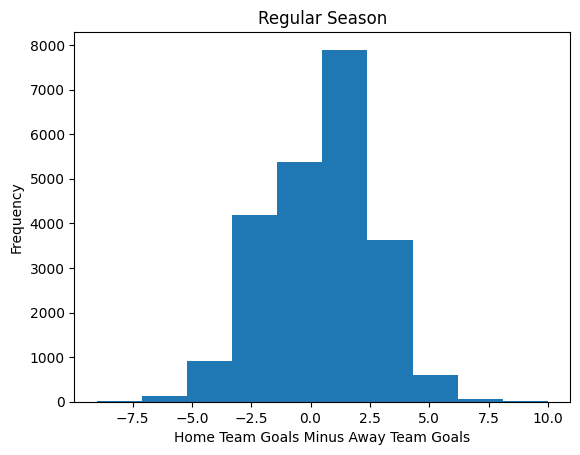

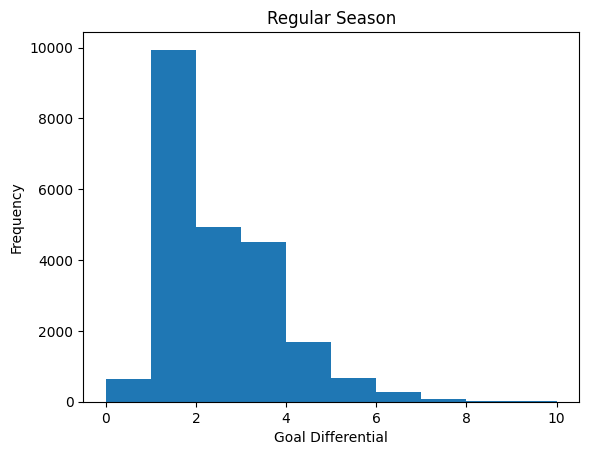

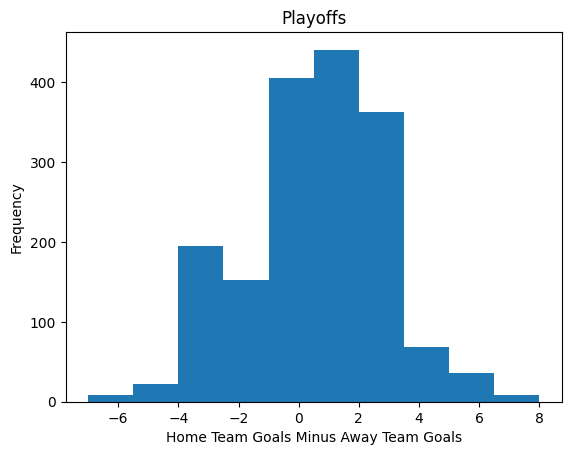

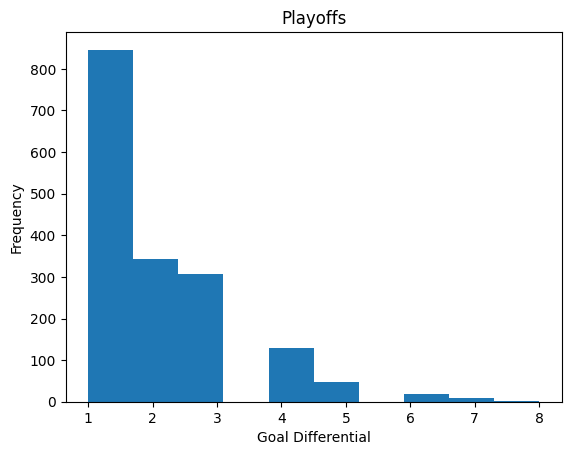

In [8]:
plt.hist(scores_in['G_HminusV'])
plt.xlabel('Home Team Goals Minus Away Team Goals')
plt.ylabel('Frequency')
plt.title('Regular Season')
plt.show()

plt.hist(scores_in['G_Diff'])
plt.xlabel('Goal Differential')
plt.ylabel('Frequency')
plt.title('Regular Season')
plt.show()

plt.hist(playoff_in['G_HminusV'])
plt.xlabel('Home Team Goals Minus Away Team Goals')
plt.ylabel('Frequency')
plt.title('Playoffs')
plt.show()

plt.hist(playoff_in['G_Diff'])
plt.xlabel('Goal Differential')
plt.ylabel('Frequency')
plt.title('Playoffs')
plt.show()

Percent of Games with Each Goal Difference Value

In [9]:
goal_diff_percentage_regular_season = 100*np.round(scores_in['G_Diff'].value_counts()/scores_in['G_Diff'].count(), decimals=5)
goal_diff_percentage_playoffs = 100*np.round(playoff_in['G_Diff'].value_counts()/playoff_in['G_Diff'].count(), decimals=5)

print(goal_diff_percentage_regular_season)
print(goal_diff_percentage_playoffs)

1.0     43.608
2.0     21.690
3.0     19.817
4.0      7.436
5.0      2.948
0.0      2.755
6.0      1.237
7.0      0.333
8.0      0.123
9.0      0.044
10.0     0.009
Name: G_Diff, dtype: float64
1    49.735
2    20.165
3    18.107
4     7.584
5     2.763
6     1.058
7     0.529
8     0.059
Name: G_Diff, dtype: float64


Net Number of Goals Scored by Team (at Home, Away, and Overall)

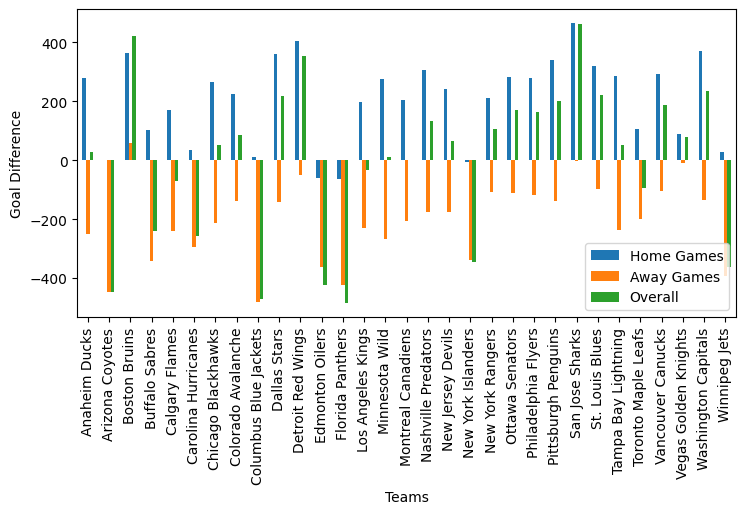

In [46]:
home_diff = scores_in.groupby('Home').sum()['G_HminusV']
visitor_diff = scores_in.groupby('Visitor').sum()['G_VminusH']
net_goal_difference = home_diff + visitor_diff

arrays = [['Goal Difference', 'Goal Difference', 'Goal Difference'],['Home Games', 'Away Games', 'Overall']]
tuples = list(zip(*arrays))
index = pd.MultiIndex.from_tuples(tuples)

goal_difference_table = pd.DataFrame([home_diff, visitor_diff, net_goal_difference], index=index).T

locations = np.arange(len(goal_difference_table))

ax = goal_difference_table['Goal Difference'].plot(kind="bar")
# Get a Matplotlib figure from the axes object for formatting purposes
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(8.5, 4)
# Change the axes labels
ax.set_xlabel("Teams")
ax.set_ylabel("Goal Difference")

plt.show()

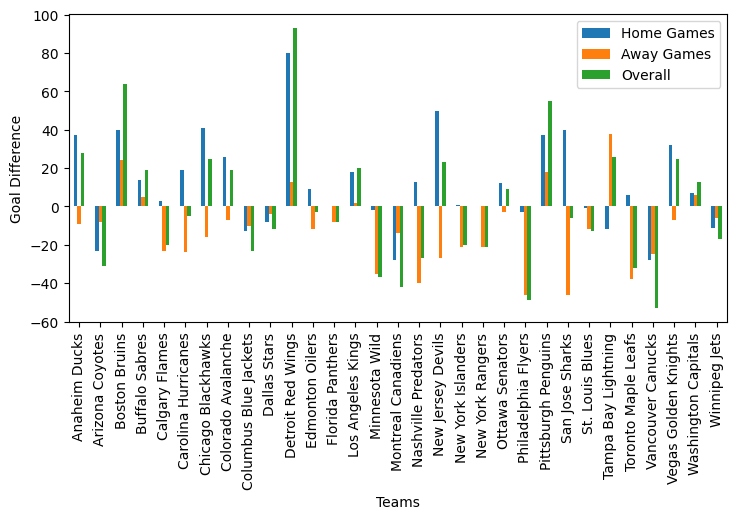

In [11]:
home_diff = playoff_in.groupby('Home').sum()['G_HminusV']
visitor_diff = playoff_in.groupby('Visitor').sum()['G_VminusH']
net_goal_difference = home_diff + visitor_diff

arrays = [['Goal Difference', 'Goal Difference', 'Goal Difference'],['Home Games', 'Away Games', 'Overall']]
tuples = list(zip(*arrays))
index = pd.MultiIndex.from_tuples(tuples)

goal_difference_table = pd.DataFrame([home_diff, visitor_diff, net_goal_difference], index=index).T

locations = np.arange(len(goal_difference_table))

ax = goal_difference_table['Goal Difference'].plot(kind="bar")
# Get a Matplotlib figure from the axes object for formatting purposes
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(8.5, 4)
# Change the axes labels
ax.set_xlabel("Teams")
ax.set_ylabel("Goal Difference")

plt.show()

Frequency of Each Goal Scored by Team Value (Regular Season and Playoffs)

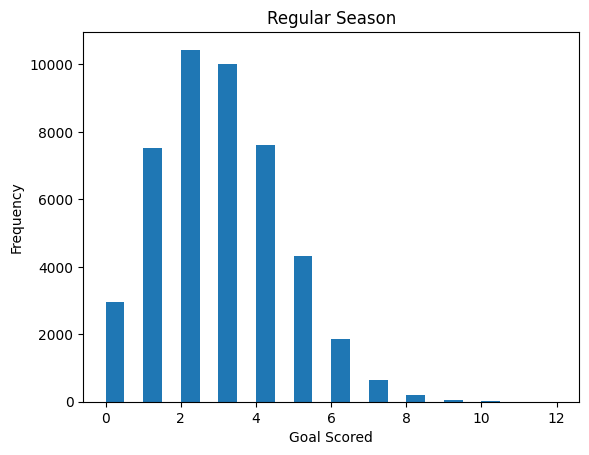

In [12]:
only_scores_home = scores_in.filter(['G_Home'])
only_scores_visitor = scores_in.filter(['G_Vis'])
only_scores = pd.concat([only_scores_home, only_scores_visitor], axis=0)
only_scores2 = only_scores['G_Home'].combine_first(only_scores['G_Vis'])
only_scores['G_Home'] = only_scores2
only_scores = only_scores.drop(['G_Vis'], axis=1)

plt.hist(only_scores, bins=24)
plt.xlabel('Goal Scored')
plt.ylabel('Frequency')
plt.title('Regular Season')
plt.show()

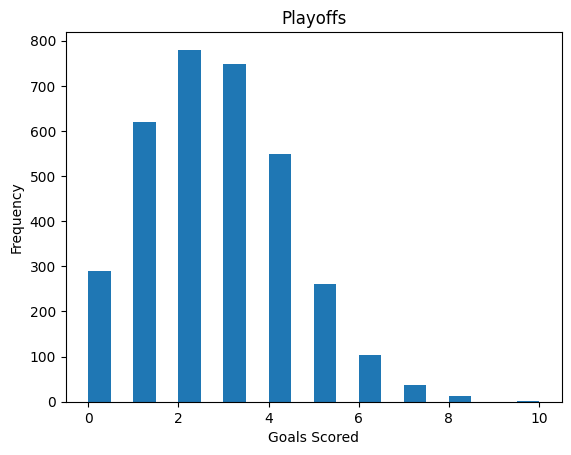

In [13]:
only_scores_home_playoffs = playoff_in.filter(['G_Home'])
only_scores_visitor_playoffs = playoff_in.filter(['G_Vis'])
only_scores_playoffs = pd.concat([only_scores_home_playoffs, only_scores_visitor_playoffs], axis=0)
only_scores2_playoffs = only_scores_playoffs['G_Home'].combine_first(only_scores_playoffs['G_Vis'])
only_scores_playoffs['G_Home'] = only_scores2_playoffs
only_scores_playoffs = only_scores_playoffs.drop(['G_Vis'], axis=1)

plt.hist(only_scores_playoffs, bins=20)
plt.xlabel('Goals Scored')
plt.ylabel('Frequency')
plt.title('Playoffs')
plt.show()

### **Investigate Overtime Percentages**

Percentage of Overtime Games Overall

In [14]:
regular_season_OT = scores_in['OT Ind'].sum()
total_regular_season_games = scores_in['OT Ind'].count()
regular_season_OT_percentage = 100*np.round(regular_season_OT/total_regular_season_games, decimals=4)

playoff_OT = playoff_in['OT Ind'].sum()
total_playoff_games = playoff_in['OT Ind'].count()
playoff_OT_percentage = 100*np.round(playoff_OT/total_playoff_games, decimals=4)

print(f'{regular_season_OT_percentage}% of regular season games went to OT')
print(f'{playoff_OT_percentage}% of playoff games went to OT')

23.44% of regular season games went to OT
18.11% of playoff games went to OT


Percentage of Overtime Games by Season

In [15]:
regular_season_OT_by_season = scores_in.groupby('Season').sum()['OT Ind']
total_regular_season_games_by_season = scores_in.groupby('Season').count()['OT Ind']
regular_season_OT_percentage_by_season = 100*np.round(regular_season_OT_by_season/total_regular_season_games_by_season, decimals=4)

playoff_OT_by_season = scores_in.groupby('Season').sum()['OT Ind']
total_playoff_games_by_season = scores_in.groupby('Season').count()['OT Ind']
playoff_OT_percentage_by_season = 100*np.round(playoff_OT_by_season/total_playoff_games_by_season, decimals=4)

arrays = [['Overtime Percentage', 'Overtime Percentage'],['Regular Season', 'Playoffs']]
tuples = list(zip(*arrays))
index = pd.MultiIndex.from_tuples(tuples)

pd.DataFrame([regular_season_OT_percentage_by_season, playoff_OT_percentage_by_season], index=index).T


Overtime Percentage         
            Regular Season Playoffs
Season                             
2001                 22.28    22.28
2002                 21.95    21.95
2003                 25.45    25.45
2004                 25.61    25.61
2006                 22.85    22.85
2007                 22.85    22.85
2008                 22.11    22.11
2009                 22.93    22.93
2010                 24.47    24.47
2011                 24.15    24.15
2012                 24.39    24.39
2013                 22.50    22.50
2014                 24.96    24.96
2015                 24.88    24.88
2016                 22.36    22.36
2017                 23.50    23.50
2018                 23.29    23.29
2019                 21.32    21.32
2020                 23.11    23.11

### **Investigate Win/Loss Results**

Determine Wins, Losses, Ties, Home OT Losses and Away OT Losses

In [16]:
def winloss(df):
  scores_in2 = df.copy()
  scores_in2['H_Win'] = np.nan
  scores_in2['V_Win'] = np.nan
  scores_in2['Tie'] = np.nan
  scores_in2['OT_H_Loss'] = np.nan
  scores_in2['OT_V_Loss'] = np.nan

  for i in range(0, len(scores_in2)):
    if scores_in2['G_Home'][i] > scores_in2['G_Vis'][i]:
      scores_in2['H_Win'][i] = 1
      if scores_in2['OT Ind'][i] == 1:
        scores_in2['OT_V_Loss'][i] = 1

    elif scores_in2['G_Home'][i] < scores_in2['G_Vis'][i]:
      scores_in2['V_Win'][i] = 1
      if scores_in2['OT Ind'][i] == 1:
        scores_in2['OT_H_Loss'][i] = 1

    else:
      scores_in2['Tie'][i] = 1


  scores_in2.groupby('Home').sum()
  scores_in2.head()

  return(scores_in2)

Create Table of Wins, Losses, Ties, OT Losses and Points

In [17]:
def point_table(scores_in2):
  team_wins = scores_in2.groupby('Home').sum()['H_Win'] + scores_in2.groupby('Visitor').sum()['V_Win']
  team_losses = scores_in2.groupby('Home').sum()['V_Win'] + scores_in2.groupby('Visitor').sum()['H_Win']
  team_ties = scores_in2.groupby('Home').sum()['Tie'] + scores_in2.groupby('Visitor').sum()['Tie']
  team_OT_losses = scores_in2.groupby('Home').sum()['OT_H_Loss'] + scores_in2.groupby('Visitor').sum()['OT_V_Loss']
  win_loss_record = pd.DataFrame([team_wins, team_losses-team_OT_losses, team_ties, team_OT_losses], index=['Wins', 'Losses', 'Ties', 'OT Losses']).T

  win_loss_record['Points'] = 2*win_loss_record['Wins'] + (win_loss_record['Ties'] + win_loss_record['OT Losses'])
  #print(win_loss_record.mean())
  #print(win_loss_record.std())
  win_loss_record.sort_values('Points', ascending=False)

  return(win_loss_record)

### **Investigate League-wide Results After League Expansion**

*(Note: Minnesota Wild and Columbus Blue Jackets joined NHL in 2000-01 season and Vegas Golden Knights joined in 2017-18 season)*

First 3 Seasons in NHL

In [18]:
display(point_table(winloss(expansion1)).sort_values('Points', ascending=False)) # First 3 seasons after 2000-01 expansion

display(point_table(winloss(expansion2)).sort_values('Points', ascending=False)) # First 3 seasons after 2017-18 expansion

,Wins,Losses,Ties,OT Losses,Points
Home,,,,,
Detroit Red Wings,148.0,57.0,29.0,12.0,337.0
Colorado Avalanche,139.0,63.0,31.0,13.0,322.0
Ottawa Senators,139.0,69.0,26.0,12.0,316.0
New Jersey Devils,135.0,67.0,31.0,13.0,314.0
Dallas Stars,130.0,69.0,36.0,11.0,307.0
Philadelphia Flyers,130.0,72.0,34.0,10.0,304.0
St. Louis Blues,127.0,73.0,31.0,15.0,300.0
Toronto Maple Leafs,124.0,82.0,28.0,12.0,288.0
Vancouver Canucks,123.0,81.0,31.0,11.0,288.0


,Wins,Losses,Ties,OT Losses,Points
Home,,,,,
Tampa Bay Lightning,159.0,60.0,0.0,15.0,333.0
Boston Bruins,143.0,58.0,0.0,33.0,319.0
Washington Capitals,138.0,72.0,0.0,23.0,299.0
Nashville Predators,135.0,73.0,0.0,25.0,295.0
Winnipeg Jets,136.0,78.0,0.0,21.0,293.0
Vegas Golden Knights,133.0,80.0,0.0,22.0,288.0
St. Louis Blues,131.0,79.0,0.0,25.0,287.0
Pittsburgh Penguins,131.0,78.0,0.0,24.0,286.0
Toronto Maple Leafs,131.0,79.0,0.0,24.0,286.0


First 2 Seasons in NHL

In [20]:
expansion1_2 = expansion1[expansion1['Season'] < 2003]
expansion2_2 = expansion2[expansion2['Season'] < 2020]

display(point_table(winloss(expansion1_2)).sort_values('Points', ascending=False)) # First 2 seasons after 2000-01 expansion

display(point_table(winloss(expansion2_2)).sort_values('Points', ascending=False)) # First 2 seasons after 2017-18 expansion

,Wins,Losses,Ties,OT Losses,Points
Home,,,,,
Detroit Red Wings,100.0,37.0,19.0,8.0,227.0
Colorado Avalanche,97.0,44.0,18.0,5.0,217.0
New Jersey Devils,89.0,47.0,21.0,7.0,206.0
Ottawa Senators,87.0,48.0,18.0,11.0,203.0
St. Louis Blues,86.0,49.0,20.0,9.0,201.0
Philadelphia Flyers,85.0,52.0,21.0,6.0,197.0
Dallas Stars,84.0,52.0,21.0,7.0,196.0
San Jose Sharks,84.0,54.0,20.0,6.0,194.0
Toronto Maple Leafs,80.0,54.0,21.0,9.0,190.0


,Wins,Losses,Ties,OT Losses,Points
Home,,,,,
Tampa Bay Lightning,116.0,39.0,0.0,9.0,241.0
Boston Bruins,99.0,44.0,0.0,21.0,219.0
Nashville Predators,100.0,47.0,0.0,17.0,217.0
Winnipeg Jets,99.0,50.0,0.0,15.0,213.0
Washington Capitals,97.0,52.0,0.0,15.0,209.0
Toronto Maple Leafs,95.0,54.0,0.0,15.0,205.0
Vegas Golden Knights,94.0,56.0,0.0,14.0,202.0
San Jose Sharks,91.0,54.0,0.0,19.0,201.0
Pittsburgh Penguins,91.0,55.0,0.0,18.0,200.0


### **Win Probability for Home and Away Games**

Win Probability Graph

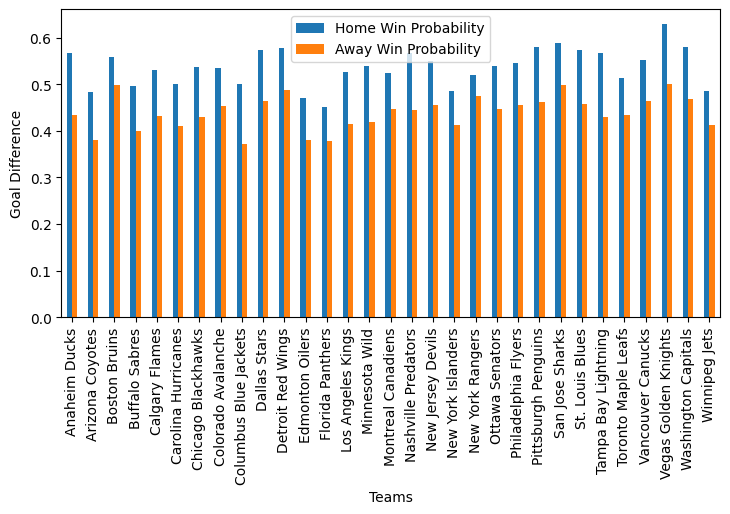

In [47]:
scores_in_HvV = winloss(scores_in)

home_wins = scores_in_HvV.groupby('Home').sum()['H_Win']
visitor_wins = scores_in_HvV.groupby('Visitor').sum()['V_Win']
num_home_games = scores_in_HvV.groupby('Home').count()['OT Ind']
num_visitor_games = scores_in_HvV.groupby('Visitor').count()['OT Ind']
home_win_probability = home_wins/num_home_games
visitor_win_probability = visitor_wins/num_visitor_games

win_probabilities = pd.DataFrame([home_win_probability, visitor_win_probability], index=['Home Win Probability', 'Away Win Probability']).T

locations = np.arange(len(goal_difference_table))

ax = win_probabilities.plot(kind="bar")
fig = ax.get_figure()
fig.set_size_inches(8.5, 4)
ax.set_xlabel("Teams")
ax.set_ylabel("Goal Difference")

plt.show()

Average Win Probability

In [50]:
average_home_win_probability = home_win_probability.mean()
average_visitor_win_probability = visitor_win_probability.mean()
average_win_probability_difference = (home_win_probability-visitor_win_probability).mean()

print(f'The average win probability for home games is {100*np.round(average_home_win_probability, decimals=4)}%')
print(f'The average win probability for away games is {100*np.round(average_visitor_win_probability, decimals=4)}%')
print(f'The average difference in win probability between home and away games is {100*np.round(average_win_probability_difference, decimals=4)}%')

The average win probability for home games is 53.74%
The average win probability for away games is 43.94%
The average difference in win probability between home and away games is 9.8%
